In [1]:

import torch
import os
import sys
import yaml
import json
import multiprocessing
from glob import glob
from skimage import io, transform
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn.modules.module import _addindent
import numpy as np
from PIL import Image
import re
import time
from tqdm import tqdm
from scipy.interpolate import interp1d
import torchvision
from torch.utils.data import Dataset
import pandas as pd
import math
from multiprocessing.pool import Pool
import cv2
from torchsummary import summary
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn import svm
from sklearn.cluster import KMeans
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from albumentations import JpegCompression
from skimage.color import rgb2hsv
from sklearn.mixture import GaussianMixture
from scipy.stats import kurtosis, skew
from scipy.fftpack import dct 
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error, classification_report, roc_curve, roc_auc_score
from torch.utils.data import DataLoader
from torchsummary import summary
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2, 3"
seed = int(time.time())
torch.manual_seed(seed)
np.random.seed(seed)

In [62]:
def visualize_scatter(data_2d, label_ids, figsize=(10,12)):
    plt.figure(figsize=figsize)
    plt.grid()
    colors = ['g', 'r', 'o']
    nb_classes = len(np.unique(label_ids))
    
    for idx, label_id in enumerate(np.unique(label_ids)):
        plt.scatter(data_2d[np.where(label_ids == label_id), 0],
                    data_2d[np.where(label_ids == label_id), 1],
                    marker='o',
                    color= colors[idx], #plt.cm.Set1(label_id / float(nb_classes)),
                    linewidth='1',
                    alpha=0.8,
                    label=str(label_id))
    plt.legend(loc='best')

def fft_img_func(ip_img, mode=-1, val='modulus'):
        im = ip_img/255.0
        for i in range(3):
            img = im[:,:,i]
            fft_img = np.fft.fft2(img) # Fourier transform 2 dimetional
            fft_img = np.fft.fftshift(fft_img)
            if val=='modulus': 
                fft_img = np.log(np.abs(fft_img)+1e-3)
            else: 
                fft_img = np.angle(fft_img)
            fft_min = np.percentile(fft_img,1)
            fft_max = np.percentile(fft_img,99)
            fft_img = (fft_img - fft_min)/(fft_max - fft_min) # -> [0,1]
#             fft_img = (fft_img-0.5)*2 # -> [-1,1]
#             fft_img[fft_img<-1] = -1
            fft_img[fft_img<0.0] = 0.0
            fft_img[fft_img>1] = 1
            #set mid and high freq to 0
            if mode>0:
                fft_img = np.fft.fftshift(fft_img)
                if mode == 1:
                    fft_img[:57, :] = 0
                    fft_img[:, :57] = 0
                    fft_img[177:, :] = 0
                    fft_img[:, 177:] = 0
                #set low and high freq to 0
                elif mode == 2:
                    fft_img[:21, :] = 0
                    fft_img[:, :21] = 0
                    fft_img[203:, :] = 0
                    fft_img[:, 203:] = 0
                    fft_img[57:177, 57:177] = 0
                #set low and mid freq to 0
                elif mode == 3:
                    fft_img[21:203, 21:203] = 0
                fft_img = np.fft.fftshift(fft_img)
            
            im[:,:,i] = fft_img

        return im
def fft_img_func_v1(ip_img):
    im = ip_img/255.0
    for i in range(3):
        img = im[:,:,i]
        f = np.fft.fft2(img)
        fshift = np.fft.fftshift(f)
        fshift += 1e-3
        fft_img = np.log(np.abs(fshift))
        fft_min = np.percentile(fft_img,1)
        fft_max = np.percentile(fft_img,99)
        fft_img = (fft_img - fft_min)/(fft_max - fft_min)
        im[:,:,i] = fft_img
    return im

def fft_img_func_v2(ip_img):
    'Consine transform'
    im = ip_img/255.0
    for i in range(3):
        img = im[:,:,i]
        f = dct(img)
        fft_img = np.log(np.abs(f + 1e-3))
        fft_min = np.percentile(fft_img,1)
        fft_max = np.percentile(fft_img,99)
        fft_img = (fft_img - fft_min)/(fft_max - fft_min)
        im[:,:,i] = fft_img
    return im
    
def color_diff(try_img):
    h, w, c = try_img.shape
    r, g, b = try_img[:,:,0].flatten() , try_img[:,:,1].flatten() , try_img[:,:,2].flatten()
    rg = np.abs(r - g)
    rb = np.abs(r - b)
    gb = np.abs(g - b)
    diff = [np.mean(rg), np.mean(rb), np.mean(gb)]
#     stat = np.vstack((rg, rb, gb)).flatten()
    
#     fact = [np.mean(diff), np.min(diff), np.max(diff), np.std(stat), kurtosis(stat), skew(stat)]
    fact = [np.mean(diff), np.min(diff), np.max(diff), 1-np.corrcoef(r,g)[0,1], 1-np.corrcoef(r,b)[0,1], 1-np.corrcoef(g,b)[0,1]]
    return fact

def fourier_transform(file, resize=(45,45)):
    fimg = cv2.imread(file)
    fimg = cv2.cvtColor(fimg, cv2.COLOR_BGR2RGB)
    fft_img = fft_img_func(fimg,-1)
#     fft_img = cv2.resize(fft_img, resize)
    return fft_img

def fft_line(fft_img):
    frequen_line = {}
    for channel in [0,1,2]:
        freq_0 = fft_img[:,:,channel]
        w, h = freq_0.shape
        assert w==h
        frequen_line[channel] = []
        x = np.linspace(0, w-1, w)
        y = np.linspace(0, h-1, h)
        xv, yv = np.meshgrid(x, y)
        xm = np.floor(np.abs((xv-(w-1)/2))).astype(np.int)
        ym = np.floor(np.abs((yv-(h-1)/2))).astype(np.int)
        a = np.stack((xm, ym))
        unique_step = np.unique(xm)

        for j in unique_step:
            c = np.logical_and(a[0,:,:]==j, a[1,:,:]==j )
            co_x, co_y = np.where(c==True)
            if len(co_x) == 4:
                con_squr = np.hstack((freq_0[co_x[0], co_y[0]:co_y[1]+1], 
                          freq_0[co_x[2], co_y[2]:co_y[3]+1],
                          freq_0[co_x[0]+1:co_x[2], co_y[0]],
                          freq_0[co_x[1]+1:co_x[3], co_y[1]]))
                frequen_line[channel].append(np.mean(con_squr))
            else: frequen_line[channel].append(freq_0[co_x, co_y])
#         frequen_line[channel] = 1 / (frequen_line[channel]/frequen_line[channel][0])
    return frequen_line

def fft_line_v1(fft_img):
    frequen_line = {}
    for channel in [0,1,2]:
        frequen_line[channel] = azimuthalAverage(fft_img[:,:,channel])
    return frequen_line

def fft_line_v2(fft_img):
    frequen_line = {}
    w,h,c = fft_img.shape
    for channel in [0,1,2]:
        frequen_line[channel] = [np.mean( np.stack((fft_img[:i,i,channel], fft_img[i,:i,channel]))) for i in range(min(w,h))]
    return frequen_line

def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

def report_results(model, scaler_transform, pca_transform, data_hub, data_name, types=['real_trans', 'fake_trans'], gmm=None):
    test_imgs = np.vstack((data_hub[data_name][types[0]], data_hub[data_name][types[1]]))
    test_lbs = np.array([1]*len(data_hub[data_name][types[0]]) + [0]*len(data_hub[data_name][types[1]]))
    if gmm is not None:
        m1, m2 = gmm.means_[np.argmin(gmm.means_[:,0])], gmm.means_[np.argmax(gmm.means_[:,0])]
        scale = m2 - m1
        test_imgs = (test_imgs - m1) / (scale)
    test_imgs_scaled = scaler_transform.transform(test_imgs) if scaler_transform is not None else test_imgs

    test_imgs_pca = pca_transform.transform(test_imgs_scaled)  if pca_transform is not None else test_imgs_scaled

    yhat = model.predict(test_imgs_pca)
    yhat[yhat==-1] = 0
    y_true = test_lbs.astype(int)
    y_pred = yhat.astype(int)

    print(f"Predicting on {data_name}")
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_true, y_pred)
    print('Accuracy: %.4f' % accuracy)
    # recall: tp / (tp + fn)
    recall = recall_score(y_true, y_pred)
    print('Recall: %.3f' % recall)
    # precision tp / (tp + fp)
    precision = precision_score(y_true, y_pred)
    print('Precision: %.3f' % precision)
    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_true, y_pred)
    print('F1 score: %.3f\n' % f1)
    
def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.
    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

In [3]:
data = {}

data['FakeTalker'] = {
    'real': glob('./data/FakeTalker/train/0_real/*.png'), #[:1000],
    'fake': glob('./data/FakeTalker/train/1_fake/*.png') #[:1000]
}

data['FakeTalker_test'] = {
    'real': glob('./data/FakeTalker/test50/0_real/*.png'), #[:1000],
    'fake': glob('./data/FakeTalker/test50/1_fake/*.png') #[:1000]
}

data['StarGAN'] = {
    'real':glob('../GAN dataset/Multiple types/test/stargan/0_real/*.png')[:1000], 
    'fake': glob('../GAN dataset/Multiple types/test/stargan/1_fake/*.png')[:1000]
}
data['StarGAN_test'] = {
    'real':glob('../GAN dataset/Multiple types/test/stargan/0_real/*.png')[1000:2000], 
    'fake': glob('../GAN dataset/Multiple types/test/stargan/1_fake/*.png')[1000:2000]
}
##################
data['StyleGAN'] = {
    'real':glob('../GAN dataset/FFHQ/11000/*.png')[:1000], 
    'fake': glob('../GAN dataset/StyleGAN/002000/*.png')[:1000]
}

data['StyleGAN_test'] = {
    'real':glob('../GAN dataset/FFHQ/17000/*.png')[:1000], 
    'fake': glob('../GAN dataset/StyleGAN/005000/*.png')[:1000]
}

data['ALAE'] = {
    'real':glob('../GAN dataset/FFHQ/11000/*.png')[:1000], 
    'fake': glob('../GAN dataset/ALAE/00001/*.png')[:1000]
}
data['ALAE_test'] = {
    'real':glob('../GAN dataset/FFHQ/17000/*.png')[:1000], 
    'fake': glob('../GAN dataset/ALAE/00002/*.png')[:1000]
}


for key in data.keys():
    print(key)
    print("\tReal: ", len(data[key]['real']))
    print("\tFake: ", len(data[key]['fake']))
    


FakeTalker
	Real:  9400
	Fake:  9400
FakeTalker_test
	Real:  9400
	Fake:  9400
StarGAN
	Real:  1000
	Fake:  1000
StarGAN_test
	Real:  999
	Fake:  999
StyleGAN
	Real:  1000
	Fake:  1000
StyleGAN_test
	Real:  1000
	Fake:  1000
ALAE
	Real:  1000
	Fake:  1000
ALAE_test
	Real:  1000
	Fake:  1000


In [25]:
three_mode = [r'$Mean$', r'$Min$', r'$Max$', r'$iCorr_(RG)$', r'$iCorr_(RB)$', r'$iCorr_(GB)$']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


*************FakeTalker****************
(224, 224, 3) (224, 224, 3)


/home/binh/anaconda3/envs/daicon_deepfake/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  fig.canvas.print_figure(bytes_io, **kw)


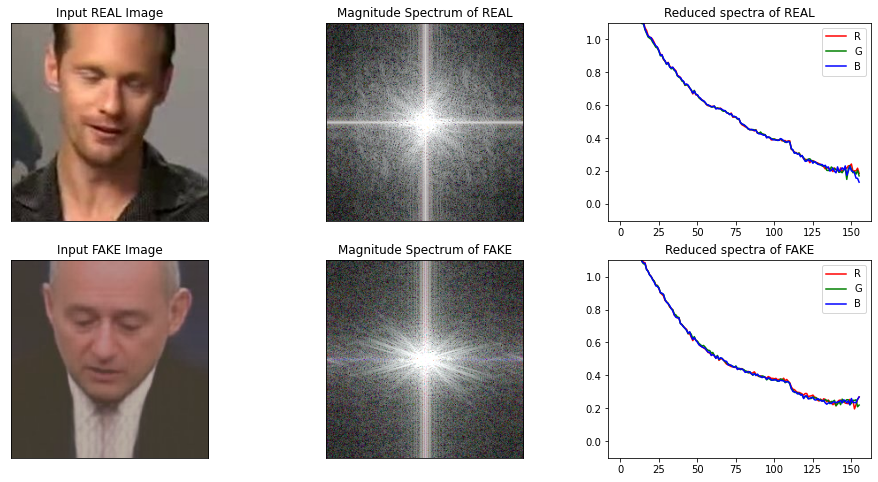

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


*************StarGAN****************
(256, 256, 3) (256, 256, 3)


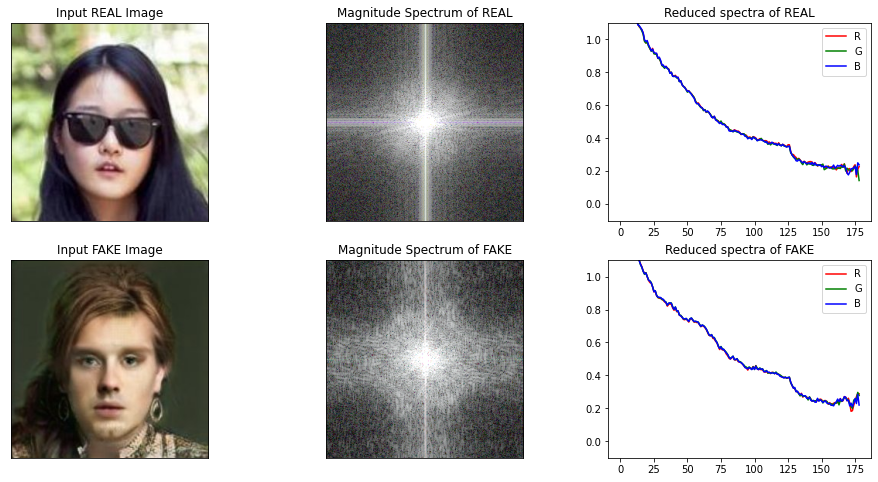

*************StyleGAN****************
(1024, 1024, 3) (1024, 1024, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


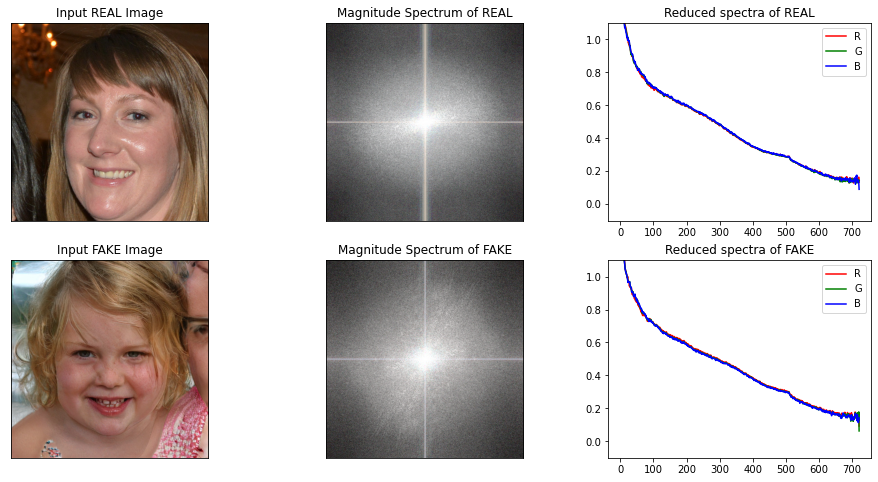

*************ALAE****************
(1024, 1024, 3) (1024, 1024, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


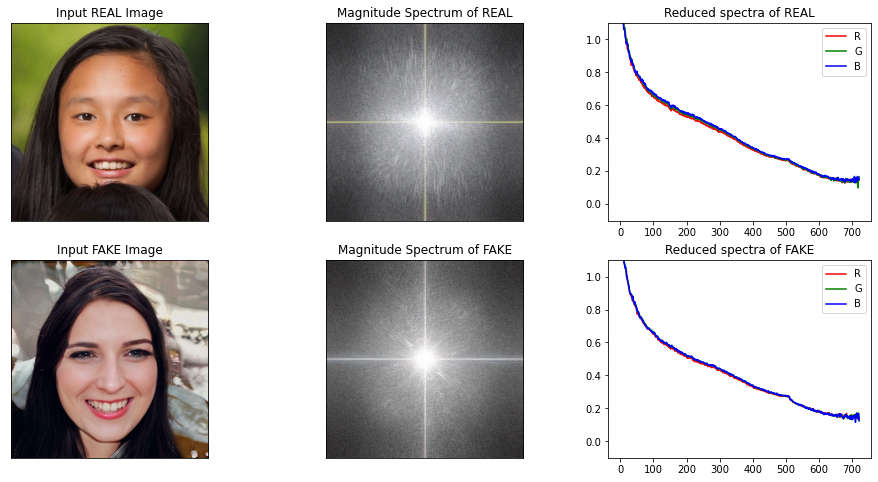

In [5]:
COLOR = ['R', 'G', 'B']
COMPRESS = 85
tmp_path_r = './tmp/tmp_r.jpg'
tmp_path_f = './tmp/tmp_f.jpg'
for key in data.keys():
    if 'test' not in key:
        print(f"*************{key}****************")
        for i in range(1):
            sample_real =data[key]['real'][np.random.choice(np.arange(len(data[key]['real'])))]
            rimg = cv2.imread(sample_real)
            rimg = cv2.cvtColor(rimg, cv2.COLOR_BGR2RGB)
            if COMPRESS < 100: 
                rimg = JpegCompression(COMPRESS, COMPRESS,p=1)(image=rimg)["image"]
            
            
            
            sample_fake =data[key]['fake'][np.random.choice(np.arange(len(data[key]['fake'])))]
            fimg = cv2.imread(sample_fake)
            fimg = cv2.cvtColor(fimg, cv2.COLOR_BGR2RGB)
            if COMPRESS < 100: 
                fimg = JpegCompression(COMPRESS, COMPRESS,p=1)(image=fimg)["image"]

            

            print(rimg.shape, fimg.shape)
            
#             fft_rimg = fft_img_func(rimg) ##---> fourier transform
#             fft_fimg = fft_img_func(fimg)
            
#             frequen_rline = fft_line(fft_rimg) ## ---> Using square
#             frequen_fline = fft_line(fft_fimg)

            
            fft_rimg = fft_img_func_v1(rimg)
            fft_fimg = fft_img_func_v1(fimg)

#             fft_rimg = fft_img_func_v2(rimg) ## ---> Consine transform
#             fft_fimg = fft_img_func_v2(fimg)
        
            frequen_rline = fft_line_v1(fft_rimg) ## ---> Using circle
            frequen_fline = fft_line_v1(fft_fimg)
            
#             frequen_rline = fft_line_v2(fft_rimg) ## ---> Reduced spectrum of Cosine transform
#             frequen_fline = fft_line_v2(fft_fimg)

            plt.figure(figsize=(16,8))
            plt.subplot(231),plt.imshow(rimg, cmap = 'gray')
            plt.title('Input REAL Image'), plt.xticks([]), plt.yticks([])
            plt.subplot(232),plt.imshow(fft_rimg[:,:,:])
            plt.title('Magnitude Spectrum of REAL'), plt.xticks([]), plt.yticks([])
            plt.subplot(233)
            for l in range(3): plt.plot(frequen_rline[l][:]/frequen_fline[l][20], color=COLOR[l], label=COLOR[l])
            plt.legend()
            plt.title('Reduced spectra of REAL'), plt.ylim([-0.1,1.1])

            plt.subplot(234),plt.imshow(fimg, cmap = 'gray')
            plt.title('Input FAKE Image'), plt.xticks([]), plt.yticks([])
            plt.subplot(235),plt.imshow(fft_fimg[:,:,:])
            plt.title('Magnitude Spectrum of FAKE'), plt.xticks([]), plt.yticks([])
            plt.subplot(236)
            for l in range(3): plt.plot(frequen_fline[l][:]/frequen_fline[l][20], color=COLOR[l], label=COLOR[l])
            plt.legend()
            plt.title('Reduced spectra of FAKE'),  plt.ylim([-0.1,1.1])
            plt.show()


### Main idea:

Every color image includes 3 channels R, G, B: 
$$ I = [R | G | B]$$
We applied Fourier transform to each channels:
$$ F_R = Fourier(R), F_G = Fourier(G), F_B = Fourier(B) $$
Our statictis is the average absolute difference of each channel with another:
$$ Stat = [\frac{1}{n} \sum |F_R-F_G|, \frac{1}{n} \sum |F_R-F_B|, \frac{1}{n} \sum |F_G-F_B|] $$

In [7]:
### Set up
visualize  = 1000


In [28]:
three_mode = [r'$Mean$', r'$Min$', r'$Max$', r'$iCorr_{RG}$', r'$iCorr_{RB}$', r'$iCorr_{GB}$']

### Fake Talker Dataset

In [8]:
key = 'FakeTalker'
data[key]['real_stat'] = []
data[key]['fake_stat'] = []
data[key]['real_trans'] = []
data[key]['fake_trans'] = []
sample_real = data[key]['real'][:]
sample_fake =data[key]['fake'][:]

with Pool(processes=72) as p:
        with tqdm(total=len(sample_real)) as pbar:
            for fft_rimg in p.imap(fourier_transform, sample_real):
#                 data[key]['real_trans'].append(fft_rimg.flatten())
                data[key]['real_stat'].append(color_diff(fft_rimg))
                del fft_rimg
                pbar.update()  

with Pool(processes=72) as p:
        with tqdm(total=len(sample_fake)) as pbar:
            for fft_fimg in p.imap(fourier_transform, sample_fake):
#                 data[key]['fake_trans'].append(fft_fimg.flatten())
                data[key]['fake_stat'].append(color_diff(fft_fimg))
                del fft_fimg
                pbar.update() 


100%|██████████| 9400/9400 [00:38<00:00, 247.15it/s]


In [113]:
plt.rcParams.update({'font.size': 20})

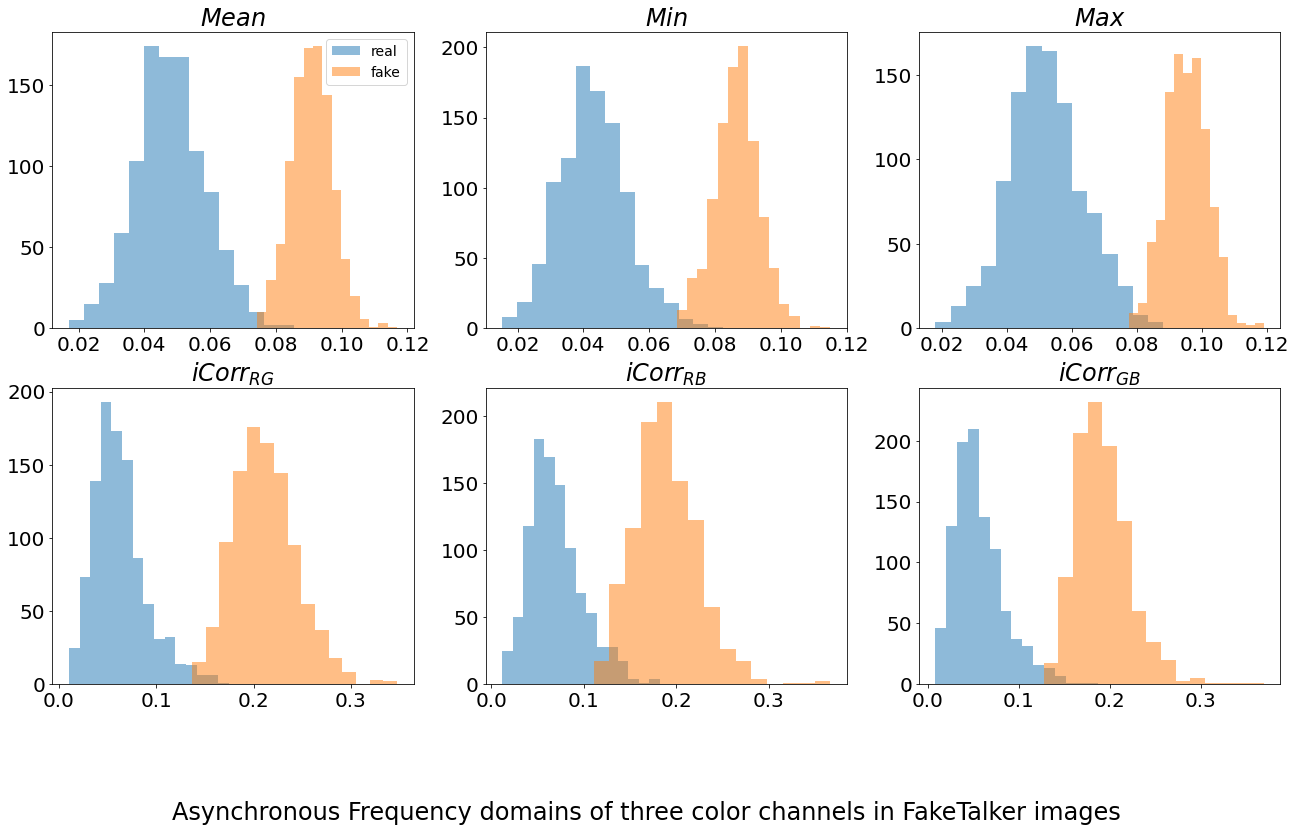

In [118]:
key = 'FakeTalker'
plt.figure(figsize=(22,12))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.hist(np.array(data[key]['real_stat'])[:visualize,i], bins=15, alpha=0.5, label='real')
    plt.hist(np.array(data[key]['fake_stat'])[:visualize,i], bins=15, alpha=0.5, label='fake')

    if i==0:plt.legend(loc='upper right', fontsize=14)
    plt.title(f"{three_mode[i]}")
plt.suptitle(f"Asynchronous Frequency domains of three color channels in {key} images",  y=-0.01)
plt.savefig(f"./figures/ablations/{key}_historam.png")
plt.show()

In [38]:
key = 'FakeTalker_test'
data[key]['real_stat'] = []
data[key]['fake_stat'] = []
data[key]['real_trans'] = []
data[key]['fake_trans'] = []
sample_real = data[key]['real'][:]
sample_fake =data[key]['fake'][:]

with Pool(processes=72) as p:
        with tqdm(total=len(sample_real)) as pbar:
            for fft_rimg in p.imap(fourier_transform, sample_real):
#                 data[key]['real_trans'].append(fft_rimg.flatten())
                data[key]['real_stat'].append(color_diff(fft_rimg))
                del fft_rimg
                pbar.update()  

with Pool(processes=72) as p:
        with tqdm(total=len(sample_fake)) as pbar:
            for fft_fimg in p.imap(fourier_transform, sample_fake):
#                 data[key]['fake_trans'].append(fft_fimg.flatten())
                data[key]['fake_stat'].append(color_diff(fft_fimg))
                del fft_fimg
                pbar.update()   

100%|██████████| 9400/9400 [00:57<00:00, 163.04it/s]


### StarGAN

In [11]:
key = 'StarGAN'
data[key]['real_stat'] = []
data[key]['fake_stat'] = []
data[key]['real_trans'] = []
data[key]['fake_trans'] = []
sample_real = data[key]['real'][:]
sample_fake =data[key]['fake'][:]

with Pool(processes=72) as p:
        with tqdm(total=len(sample_real)) as pbar:
            for fft_rimg in p.imap(fourier_transform, sample_real):
#                 data[key]['real_trans'].append(fft_rimg.flatten())
                data[key]['real_stat'].append(color_diff(fft_rimg))
                del fft_rimg
                pbar.update()  

with Pool(processes=72) as p:
        with tqdm(total=len(sample_fake)) as pbar:
            for fft_fimg in p.imap(fourier_transform, sample_fake):
#                 data[key]['fake_trans'].append(fft_fimg.flatten())
                data[key]['fake_stat'].append(color_diff(fft_fimg))
                del fft_fimg
                pbar.update()    

100%|██████████| 1000/1000 [00:04<00:00, 211.36it/s]


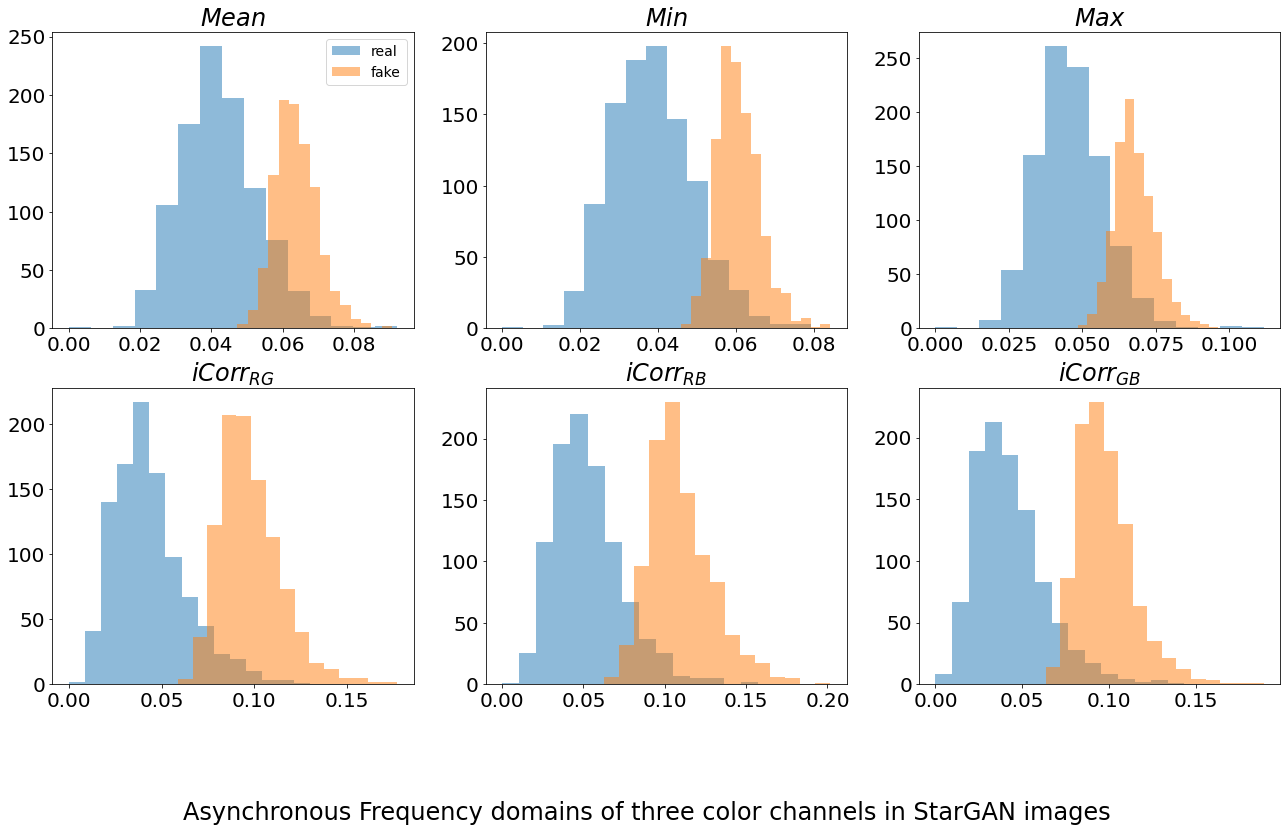

In [120]:
key = 'StarGAN'
plt.figure(figsize=(22,12))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.hist(np.array(data[key]['real_stat'])[:visualize,i], bins=15, alpha=0.5, label='real')
    plt.hist(np.array(data[key]['fake_stat'])[:visualize,i], bins=15, alpha=0.5, label='fake')
#     if i > 3: plt.xlim(0,4)
    if i==0:plt.legend(loc='upper right', fontsize=14)
    plt.title(f"{three_mode[i]}")
plt.suptitle(f"Asynchronous Frequency domains of three color channels in {key} images",  y=-0.01)
plt.savefig(f"./figures/ablations/{key}_historam.png")
plt.show()

In [12]:
key = 'StarGAN_test'
data[key]['real_stat'] = []
data[key]['fake_stat'] = []
data[key]['real_trans'] = []
data[key]['fake_trans'] = []
sample_real = data[key]['real'][:]
sample_fake =data[key]['fake'][:]

with Pool(processes=72) as p:
        with tqdm(total=len(sample_real)) as pbar:
            for fft_rimg in p.imap(fourier_transform, sample_real):
#                 data[key]['real_trans'].append(fft_rimg.flatten())
                data[key]['real_stat'].append(color_diff(fft_rimg))
                del fft_rimg
                pbar.update()  

with Pool(processes=72) as p:
        with tqdm(total=len(sample_fake)) as pbar:
            for fft_fimg in p.imap(fourier_transform, sample_fake):
#                 data[key]['fake_trans'].append(fft_fimg.flatten())
                data[key]['fake_stat'].append(color_diff(fft_fimg))
                del fft_fimg
                pbar.update()    

100%|██████████| 999/999 [00:08<00:00, 116.19it/s]


### Style GAN

In [13]:
key = 'StyleGAN'
data[key]['real_stat'] = []
data[key]['fake_stat'] = []
data[key]['real_trans'] = []
data[key]['fake_trans'] = []
sample_real = data[key]['real'][:]
sample_fake =data[key]['fake'][:]

with Pool(processes=72) as p:
        with tqdm(total=len(sample_real)) as pbar:
            for fft_rimg in p.imap(fourier_transform, sample_real):
#                 data[key]['real_trans'].append(fft_rimg.flatten())
                data[key]['real_stat'].append(color_diff(fft_rimg))
                del fft_rimg
                pbar.update()  

with Pool(processes=72) as p:
        with tqdm(total=len(sample_fake)) as pbar:
            for fft_fimg in p.imap(fourier_transform, sample_fake):
#                 data[key]['fake_trans'].append(fft_fimg.flatten())
                data[key]['fake_stat'].append(color_diff(fft_fimg))
                del fft_fimg
                pbar.update()    

100%|██████████| 1000/1000 [01:30<00:00, 11.04it/s]


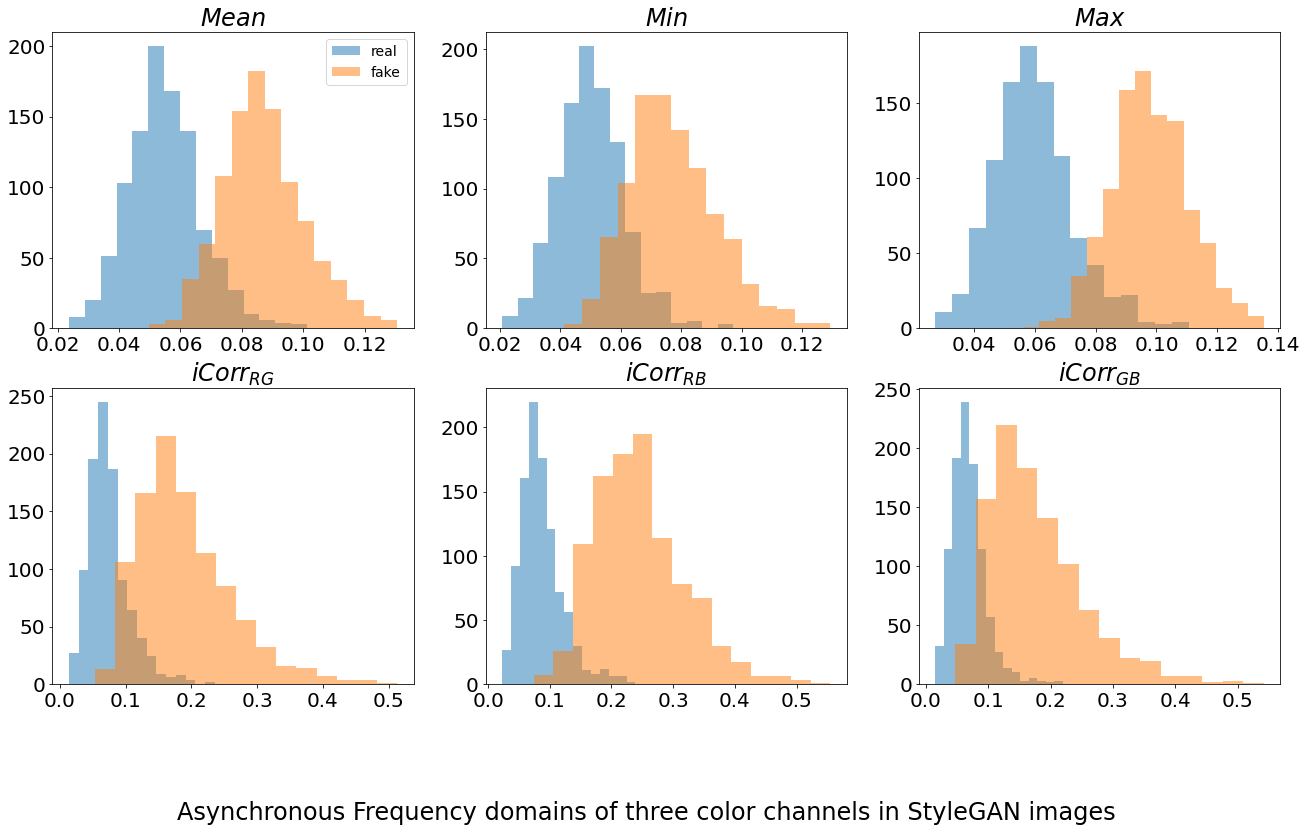

In [121]:
key = 'StyleGAN'
plt.figure(figsize=(22,12))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.hist(np.array(data[key]['real_stat'])[:visualize,i], bins=15, alpha=0.5, label='real')
    plt.hist(np.array(data[key]['fake_stat'])[:visualize,i], bins=15, alpha=0.5, label='fake')
#     if i > 3: plt.xlim(0,4)
    if i==0:plt.legend(loc='upper right', fontsize=14)
    plt.title(f"{three_mode[i]}")
plt.suptitle(f"Asynchronous Frequency domains of three color channels in {key} images",  y=-0.01)
plt.savefig(f"./figures/ablations/{key}_historam.png")
plt.show()


In [37]:
key = 'StyleGAN_test'
data[key]['real_stat'] = []
data[key]['fake_stat'] = []
data[key]['real_trans'] = []
data[key]['fake_trans'] = []
sample_real = data[key]['real'][:]
sample_fake =data[key]['fake'][:]

with Pool(processes=72) as p:
        with tqdm(total=len(sample_real)) as pbar:
            for fft_rimg in p.imap(fourier_transform, sample_real):
#                 data[key]['real_trans'].append(fft_rimg.flatten())
                data[key]['real_stat'].append(color_diff(fft_rimg))
                del fft_rimg
                pbar.update()  

with Pool(processes=72) as p:
        with tqdm(total=len(sample_fake)) as pbar:
            for fft_fimg in p.imap(fourier_transform, sample_fake):
#                 data[key]['fake_trans'].append(fft_fimg.flatten())
                data[key]['fake_stat'].append(color_diff(fft_fimg))
                del fft_fimg
                pbar.update()  

100%|██████████| 1000/1000 [01:27<00:00, 11.39it/s]


### ALAE

In [15]:
key = 'ALAE'
data[key]['real_stat'] = []
data[key]['fake_stat'] = []
data[key]['real_trans'] = []
data[key]['fake_trans'] = []
sample_real = data[key]['real'][:]
sample_fake =data[key]['fake'][:]

with Pool(processes=72) as p:
        with tqdm(total=len(sample_real)) as pbar:
            for fft_rimg in p.imap(fourier_transform, sample_real):
#                 data[key]['real_trans'].append(fft_rimg.flatten())
                data[key]['real_stat'].append(color_diff(fft_rimg))
                del fft_rimg
                pbar.update()  

with Pool(processes=72) as p:
        with tqdm(total=len(sample_fake)) as pbar:
            for fft_fimg in p.imap(fourier_transform, sample_fake):
#                 data[key]['fake_trans'].append(fft_fimg.flatten())
                data[key]['fake_stat'].append(color_diff(fft_fimg))
                del fft_fimg
                pbar.update()    

100%|██████████| 1000/1000 [01:54<00:00,  8.73it/s]


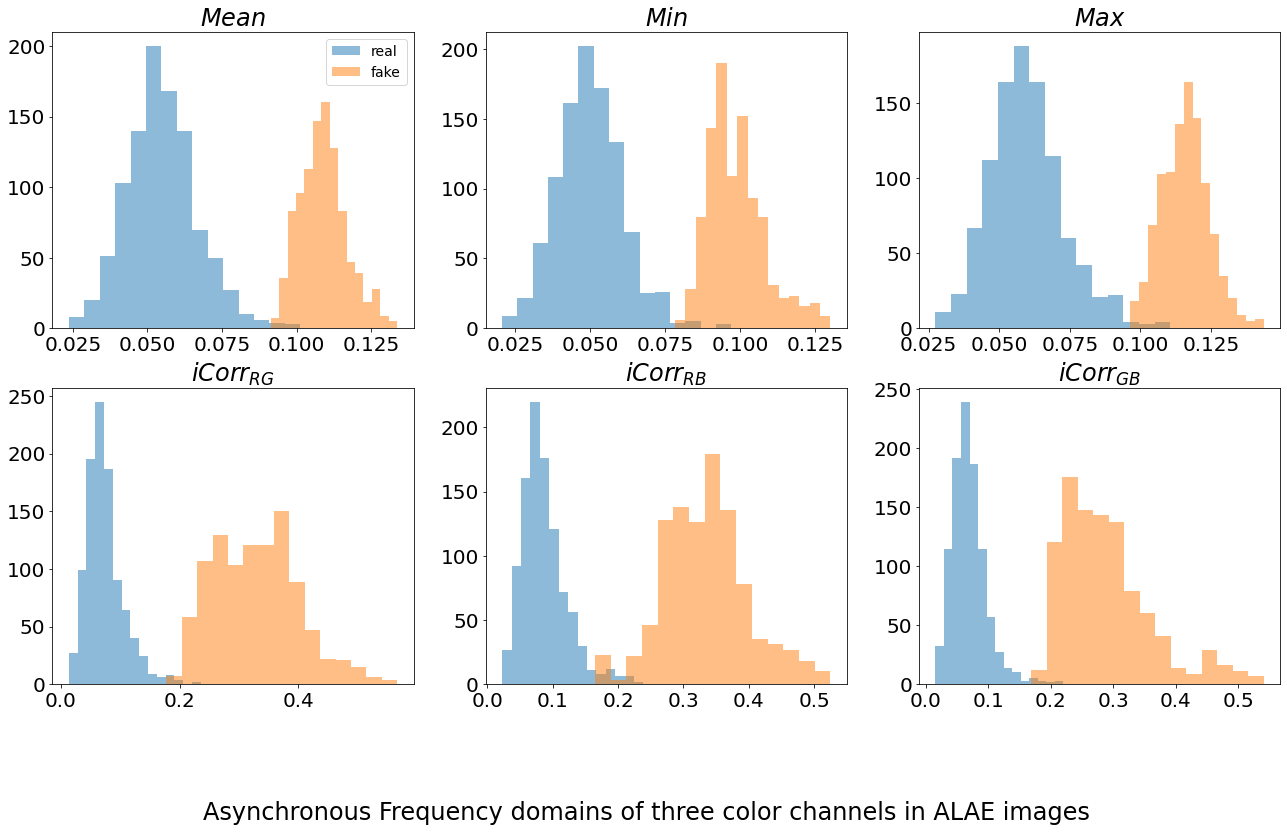

In [122]:
key = 'ALAE'
plt.figure(figsize=(22,12))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.hist(np.array(data[key]['real_stat'])[:visualize,i], bins=15, alpha=0.5, label='real')
    plt.hist(np.array(data[key]['fake_stat'])[:visualize,i], bins=15, alpha=0.5, label='fake')
#     if i > 3: plt.xlim(0,4)
    if i==0:plt.legend(loc='upper right', fontsize=14)
    plt.title(f"{three_mode[i]}")
plt.suptitle(f"Asynchronous Frequency domains of three color channels in {key} images",  y=-0.01)
plt.savefig(f"./figures/ablations/{key}_historam.png")
plt.show()

In [16]:
key = 'ALAE_test'
data[key]['real_stat'] = []
data[key]['fake_stat'] = []
data[key]['real_trans'] = []
data[key]['fake_trans'] = []
sample_real = data[key]['real'][:]
sample_fake =data[key]['fake'][:]

with Pool(processes=72) as p:
        with tqdm(total=len(sample_real)) as pbar:
            for fft_rimg in p.imap(fourier_transform, sample_real):
#                 data[key]['real_trans'].append(fft_rimg.flatten())
                data[key]['real_stat'].append(color_diff(fft_rimg))
                del fft_rimg
                pbar.update()  

with Pool(processes=72) as p:
        with tqdm(total=len(sample_fake)) as pbar:
            for fft_fimg in p.imap(fourier_transform, sample_fake):
#                 data[key]['fake_trans'].append(fft_fimg.flatten())
                data[key]['fake_stat'].append(color_diff(fft_fimg))
                del fft_fimg
                pbar.update()    

100%|██████████| 1000/1000 [02:02<00:00,  8.14it/s]


## Unsupervised by EM using statistic

In [40]:
GMM = {}

Accuracy: 0.9966
Recall: 0.999
Precision: 0.994
F1 score: 0.997



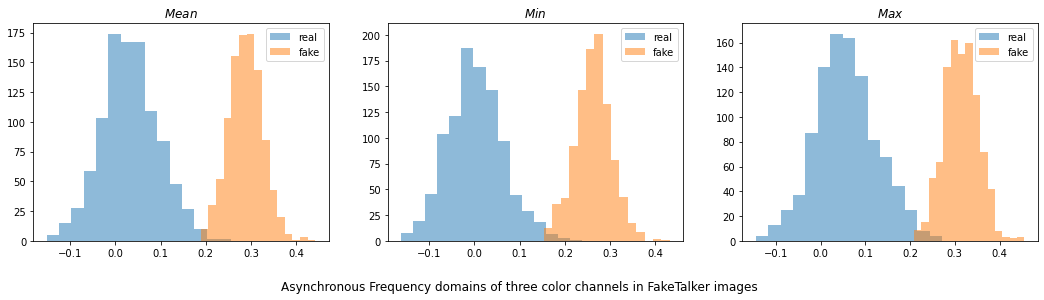

In [48]:
key='FakeTalker'
train_imgs = np.vstack((data[key]['real_stat'],data[key]['fake_stat']))
train_lbs = np.array([0]*len(data[key]['real_stat']) + [1]*len(data[key]['fake_stat']))
GMM[key] = GaussianMixture(n_components=2)
GMM[key].fit(train_imgs[:,:])


y_true = train_lbs
y_pred = GMM[key].predict(train_imgs[:,:])
accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %.4f' % accuracy)
# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred)
print('Recall: %.3f' % recall)
# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred)
print('Precision: %.3f' % precision)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, y_pred)
print('F1 score: %.3f\n' % f1)

m1, m2 = min(GMM[key].means_.flatten()), max(GMM[key].means_.flatten())
scale = m2 - m1
plt.figure(figsize=(18,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.hist((np.array(data[key]['real_stat'])[:visualize,i]-m1)/scale, bins=15, alpha=0.5, label='real')
    plt.hist((np.array(data[key]['fake_stat'])[:visualize,i]-m1)/scale, bins=15, alpha=0.5, label='fake')
    plt.legend(loc='upper right')
    plt.title(f"{three_mode[i]}")
plt.suptitle(f"Asynchronous Frequency domains of three color channels in {key} images",  y=-0.01)
plt.show()

Accuracy: 0.9205
Recall: 0.989
Precision: 0.870
F1 score: 0.926



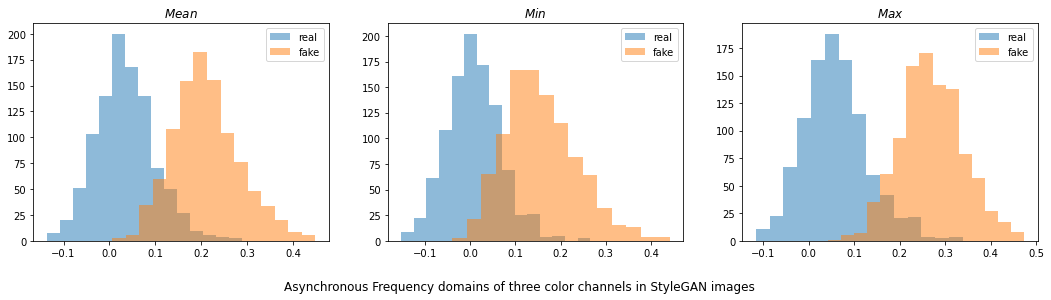

In [53]:
key='StyleGAN'
train_imgs = np.vstack((data[key]['real_stat'],data[key]['fake_stat']))
train_lbs = np.array([0]*len(data[key]['real_stat']) + [1]*len(data[key]['fake_stat']))
GMM[key] = GaussianMixture(n_components=2)
GMM[key].fit(train_imgs[:,:])

y_true = train_lbs
y_pred = GMM[key].predict(train_imgs[:,:])

accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %.4f' % accuracy)
# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred)
print('Recall: %.3f' % recall)
# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred)
print('Precision: %.3f' % precision)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, y_pred)
print('F1 score: %.3f\n' % f1)

m1, m2 = min(GMM[key].means_.flatten()), max(GMM[key].means_.flatten())
scale = m2 - m1
plt.figure(figsize=(18,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.hist((np.array(data[key]['real_stat'])[:visualize,i]-m1)/scale, bins=15, alpha=0.5, label='real')
    plt.hist((np.array(data[key]['fake_stat'])[:visualize,i]-m1)/scale, bins=15, alpha=0.5, label='fake')
    plt.legend(loc='upper right')
    plt.title(f"{three_mode[i]}")
plt.suptitle(f"Asynchronous Frequency domains of three color channels in {key} images",  y=-0.01)
plt.show()

Accuracy: 0.9034
Recall: 0.807
Precision: 1.000
F1 score: 0.893



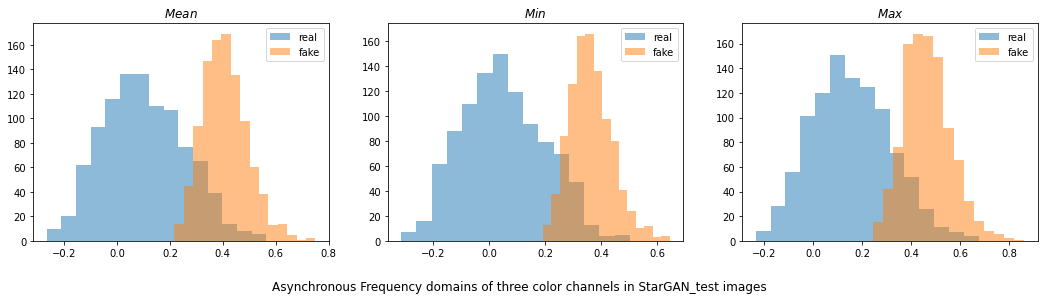

In [59]:
key='StarGAN_test'
train_imgs = np.vstack((data[key]['real_stat'],data[key]['fake_stat']))
train_lbs = np.array([1]*len(data[key]['real_stat']) + [0]*len(data[key]['fake_stat']))
GMM[key] = GaussianMixture(n_components=2)
GMM[key].fit(train_imgs[:,:])


y_true = train_lbs
y_pred = GMM[key].predict(train_imgs[:,:])
accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %.4f' % accuracy)
# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred)
print('Recall: %.3f' % recall)
# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred)
print('Precision: %.3f' % precision)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, y_pred)
print('F1 score: %.3f\n' % f1)


m1, m2 = min(GMM[key].means_.flatten()), max(GMM[key].means_.flatten())
scale = m2 - m1
plt.figure(figsize=(18,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.hist((np.array(data[key]['real_stat'])[:visualize,i]-m1)/scale, bins=15, alpha=0.5, label='real')
    plt.hist((np.array(data[key]['fake_stat'])[:visualize,i]-m1)/scale, bins=15, alpha=0.5, label='fake')
    plt.legend(loc='upper right')
    plt.title(f"{three_mode[i]}")
plt.suptitle(f"Asynchronous Frequency domains of three color channels in {key} images",  y=-0.01)
plt.show()

Accuracy: 0.9820
Recall: 0.964
Precision: 1.000
F1 score: 0.982



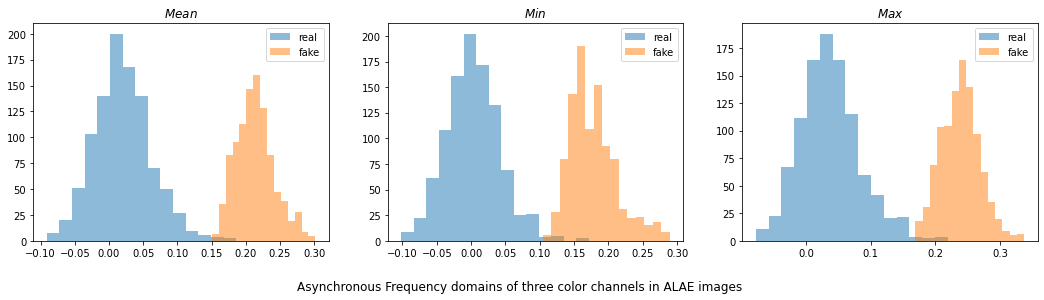

In [71]:
key='ALAE'
train_imgs = np.vstack((data[key]['real_stat'],data[key]['fake_stat']))
train_lbs = np.array([1]*len(data[key]['real_stat']) + [0]*len(data[key]['fake_stat']))
GMM[key] = GaussianMixture(n_components=2)
GMM[key].fit(train_imgs[:,:])


y_true = train_lbs
y_pred = GMM[key].predict(train_imgs[:,:])
accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %.4f' % accuracy)
# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred)
print('Recall: %.3f' % recall)
# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred)
print('Precision: %.3f' % precision)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, y_pred)
print('F1 score: %.3f\n' % f1)


m1, m2 = min(GMM[key].means_.flatten()), max(GMM[key].means_.flatten())
scale = m2 - m1
plt.figure(figsize=(18,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.hist((np.array(data[key]['real_stat'])[:visualize,i]-m1)/scale, bins=15, alpha=0.5, label='real')
    plt.hist((np.array(data[key]['fake_stat'])[:visualize,i]-m1)/scale, bins=15, alpha=0.5, label='fake')
    plt.legend(loc='upper right')
    plt.title(f"{three_mode[i]}")
plt.suptitle(f"Asynchronous Frequency domains of three color channels in {key} images",  y=-0.01)
plt.show()

## SVM with statictis data

* ### Training on FakeTalker

Using EM to translate two distribution first, then apply the SVM 

In [72]:
key =  'FakeTalker'
n_neg_sam =  int(len(data[key]['real_stat']) / (50/50))
sample_neg_idx = np.random.choice(len(data[key]['fake_stat']), n_neg_sam, replace=False)
train_imgs = np.vstack((data[key]['real_stat'], np.take(data[key]['fake_stat'], sample_neg_idx, 0)))
train_lbs = np.array([1]*len(data[key]['real_stat']) + [0]*n_neg_sam)

m1, m2 = GMM[key].means_[np.argmin(GMM[key].means_[:,0])], GMM[key].means_[np.argmax(GMM[key].means_[:,0])]
scale = m2 - m1
train_imgs = (train_imgs - m1) / (scale)

tic = time.time()
model_svm_50 = svm.SVC(kernel='rbf') # rbf Kernel
model_svm_50.fit(train_imgs, train_lbs)
toc = time.time()
print("Training time: {:.4f} - 50% Fake images".format(toc-tic))

report_results(model_svm_50, None, None, data, 'FakeTalker_test', types=['real_stat', 'fake_stat'], gmm=GMM['FakeTalker'])
report_results(model_svm_50, None, None, data, 'StyleGAN_test', types=['real_stat', 'fake_stat'], gmm=GMM['StyleGAN'])
report_results(model_svm_50, None, None, data, 'StarGAN_test', types=['real_stat', 'fake_stat'], gmm=GMM['StarGAN'])
report_results(model_svm_50, None, None, data, 'ALAE_test', types=['real_stat', 'fake_stat'], gmm=GMM['ALAE'])

Training time: 0.1278 - 50% Fake images
Predicting on FakeTalker_test
Accuracy: 0.9972
Recall: 0.994
Precision: 1.000
F1 score: 0.997

Predicting on StyleGAN_test
Accuracy: 0.7990
Recall: 0.908
Precision: 0.745
F1 score: 0.819

Predicting on StarGAN_test
Accuracy: 0.9184
Recall: 0.844
Precision: 0.992
F1 score: 0.912

Predicting on ALAE_test
Accuracy: 0.9940
Recall: 0.995
Precision: 0.993
F1 score: 0.994



In [79]:
key =  'FakeTalker'
n_neg_sam =  int(len(data[key]['real_stat']) / (75/25))
sample_neg_idx = np.random.choice(len(data[key]['fake_stat']), n_neg_sam, replace=False)
train_imgs = np.vstack((data[key]['real_stat'], np.take(data[key]['fake_stat'], sample_neg_idx, 0)))
train_lbs = np.array([1]*len(data[key]['real_stat']) + [0]*n_neg_sam)

m1, m2 = GMM[key].means_[np.argmin(GMM[key].means_[:,0])], GMM[key].means_[np.argmax(GMM[key].means_[:,0])]
scale = m2 - m1
train_imgs = (train_imgs - m1) / (scale)

tic = time.time()
model_svm_50 = svm.SVC(kernel='rbf') # rbf Kernel
model_svm_50.fit(train_imgs, train_lbs)
toc = time.time()
print("Training time: {:.4f} - 25% Fake images".format(toc-tic))

report_results(model_svm_50, None, None, data, 'FakeTalker_test', types=['real_stat', 'fake_stat'], gmm=GMM['FakeTalker'])
report_results(model_svm_50, None, None, data, 'StyleGAN_test', types=['real_stat', 'fake_stat'], gmm=GMM['StyleGAN'])
report_results(model_svm_50, None, None, data, 'StarGAN_test', types=['real_stat', 'fake_stat'], gmm=GMM['StarGAN'])
report_results(model_svm_50, None, None, data, 'ALAE_test', types=['real_stat', 'fake_stat'], gmm=GMM['ALAE'])

Training time: 0.0555 - 25% Fake images
Predicting on FakeTalker_test
Accuracy: 0.9975
Recall: 0.995
Precision: 1.000
F1 score: 0.997

Predicting on StyleGAN_test
Accuracy: 0.7860
Recall: 0.928
Precision: 0.723
F1 score: 0.813

Predicting on StarGAN_test
Accuracy: 0.9254
Recall: 0.863
Precision: 0.986
F1 score: 0.920

Predicting on ALAE_test
Accuracy: 0.9915
Recall: 0.996
Precision: 0.987
F1 score: 0.992



In [74]:
key =  'FakeTalker'
n_neg_sam =  int(len(data[key]['real_stat']) / (95/5))
sample_neg_idx = np.random.choice(len(data[key]['fake_stat']), n_neg_sam, replace=False)
train_imgs = np.vstack((data[key]['real_stat'], np.take(data[key]['fake_stat'], sample_neg_idx, 0)))
train_lbs = np.array([1]*len(data[key]['real_stat']) + [0]*n_neg_sam)

m1, m2 = GMM[key].means_[np.argmin(GMM[key].means_[:,0])], GMM[key].means_[np.argmax(GMM[key].means_[:,0])]
scale = m2 - m1
train_imgs = (train_imgs - m1) / (scale)

tic = time.time()
model_svm_50 = svm.SVC(kernel='rbf') # rbf Kernel
model_svm_50.fit(train_imgs, train_lbs)
toc = time.time()
print("Training time: {:.4f} - 5% Fake images".format(toc-tic))

report_results(model_svm_50, None, None, data, 'FakeTalker_test', types=['real_stat', 'fake_stat'], gmm=GMM['FakeTalker'])
report_results(model_svm_50, None, None, data, 'StyleGAN_test', types=['real_stat', 'fake_stat'], gmm=GMM['StyleGAN'])
report_results(model_svm_50, None, None, data, 'StarGAN_test', types=['real_stat', 'fake_stat'], gmm=GMM['StarGAN'])
report_results(model_svm_50, None, None, data, 'ALAE_test', types=['real_stat', 'fake_stat'], gmm=GMM['ALAE'])

Training time: 0.0296 - 5% Fake images
Predicting on FakeTalker_test
Accuracy: 0.9971
Recall: 0.997
Precision: 0.997
F1 score: 0.997

Predicting on StyleGAN_test
Accuracy: 0.7425
Recall: 0.956
Precision: 0.670
F1 score: 0.788

Predicting on StarGAN_test
Accuracy: 0.9244
Recall: 0.898
Precision: 0.948
F1 score: 0.922

Predicting on ALAE_test
Accuracy: 0.9860
Recall: 0.998
Precision: 0.975
F1 score: 0.986



In [84]:
key =  'FakeTalker'
n_neg_sam =  int(len(data[key]['real_stat']) / (99/1))
sample_neg_idx = np.random.choice(len(data[key]['fake_stat']), n_neg_sam, replace=False)
train_imgs = np.vstack((data[key]['real_stat'], np.take(data[key]['fake_stat'], sample_neg_idx, 0)))
train_lbs = np.array([1]*len(data[key]['real_stat']) + [0]*n_neg_sam)

m1, m2 = GMM[key].means_[np.argmin(GMM[key].means_[:,0])], GMM[key].means_[np.argmax(GMM[key].means_[:,0])]
scale = m2 - m1
train_imgs = (train_imgs - m1) / (scale)

tic = time.time()
model_svm_50 = svm.SVC(kernel='rbf') # rbf Kernel
model_svm_50.fit(train_imgs, train_lbs)
toc = time.time()
print("Training time: {:.4f} - 1% Fake images".format(toc-tic))

report_results(model_svm_50, None, None, data, 'FakeTalker_test', types=['real_stat', 'fake_stat'], gmm=GMM['FakeTalker'])

Training time: 0.0256 - 1% Fake images
Predicting on FakeTalker_test
Accuracy: 0.9924
Recall: 0.999
Precision: 0.986
F1 score: 0.992



* ### Training on StyleGAN

In [75]:
key =  'StyleGAN'
n_neg_sam =  int(len(data[key]['real_stat']) / (50/50))
sample_neg_idx = np.random.choice(len(data[key]['fake_stat']), n_neg_sam, replace=False)
train_imgs = np.vstack((data[key]['real_stat'], np.take(data[key]['fake_stat'], sample_neg_idx, 0)))
train_lbs = np.array([1]*len(data[key]['real_stat']) + [0]*n_neg_sam)

m1, m2 = GMM[key].means_[np.argmin(GMM[key].means_[:,0])], GMM[key].means_[np.argmax(GMM[key].means_[:,0])]
scale = m2 - m1
train_imgs = (train_imgs - m1) / (scale)

tic = time.time()
model_svm_50 = svm.SVC(kernel='rbf') # rbf Kernel
model_svm_50.fit(train_imgs, train_lbs)
toc = time.time()
print("Training time: {:.4f} - 5% Fake images".format(toc-tic))

report_results(model_svm_50, None, None, data, 'FakeTalker_test', types=['real_stat', 'fake_stat'], gmm=GMM['FakeTalker'])
report_results(model_svm_50, None, None, data, 'StyleGAN_test', types=['real_stat', 'fake_stat'], gmm=GMM['StyleGAN'])
report_results(model_svm_50, None, None, data, 'StarGAN_test', types=['real_stat', 'fake_stat'], gmm=GMM['StarGAN'])
report_results(model_svm_50, None, None, data, 'ALAE_test', types=['real_stat', 'fake_stat'], gmm=GMM['ALAE'])

Training time: 0.0287 - 5% Fake images
Predicting on FakeTalker_test
Accuracy: 0.9653
Recall: 0.932
Precision: 0.998
F1 score: 0.964

Predicting on StyleGAN_test
Accuracy: 0.9510
Recall: 0.938
Precision: 0.963
F1 score: 0.950

Predicting on StarGAN_test
Accuracy: 0.9059
Recall: 0.814
Precision: 0.998
F1 score: 0.896

Predicting on ALAE_test
Accuracy: 0.9910
Recall: 0.982
Precision: 1.000
F1 score: 0.991



In [81]:
key =  'StyleGAN'
n_neg_sam =  int(len(data[key]['real_stat']) / (75/25))
sample_neg_idx = np.random.choice(len(data[key]['fake_stat']), n_neg_sam, replace=False)
train_imgs = np.vstack((data[key]['real_stat'], np.take(data[key]['fake_stat'], sample_neg_idx, 0)))
train_lbs = np.array([1]*len(data[key]['real_stat']) + [0]*n_neg_sam)

m1, m2 = GMM[key].means_[np.argmin(GMM[key].means_[:,0])], GMM[key].means_[np.argmax(GMM[key].means_[:,0])]
scale = m2 - m1
train_imgs = (train_imgs - m1) / (scale)

tic = time.time()
model_svm_50 = svm.SVC(kernel='rbf') # rbf Kernel
model_svm_50.fit(train_imgs, train_lbs)
toc = time.time()
print("Training time: {:.4f} - 25% Fake images".format(toc-tic))

report_results(model_svm_50, None, None, data, 'FakeTalker_test', types=['real_stat', 'fake_stat'], gmm=GMM['FakeTalker'])
report_results(model_svm_50, None, None, data, 'StyleGAN_test', types=['real_stat', 'fake_stat'], gmm=GMM['StyleGAN'])
report_results(model_svm_50, None, None, data, 'StarGAN_test', types=['real_stat', 'fake_stat'], gmm=GMM['StarGAN'])
report_results(model_svm_50, None, None, data, 'ALAE_test', types=['real_stat', 'fake_stat'], gmm=GMM['ALAE'])

Training time: 0.0171 - 25% Fake images
Predicting on FakeTalker_test
Accuracy: 0.9796
Recall: 0.971
Precision: 0.988
F1 score: 0.979

Predicting on StyleGAN_test
Accuracy: 0.9305
Recall: 0.970
Precision: 0.899
F1 score: 0.933

Predicting on StarGAN_test
Accuracy: 0.9294
Recall: 0.879
Precision: 0.978
F1 score: 0.926

Predicting on ALAE_test
Accuracy: 0.9995
Recall: 0.999
Precision: 1.000
F1 score: 0.999



In [82]:
key =  'StyleGAN'
n_neg_sam =  int(len(data[key]['real_stat']) / (95/5))
sample_neg_idx = np.random.choice(len(data[key]['fake_stat']), n_neg_sam, replace=False)
train_imgs = np.vstack((data[key]['real_stat'], np.take(data[key]['fake_stat'], sample_neg_idx, 0)))
train_lbs = np.array([1]*len(data[key]['real_stat']) + [0]*n_neg_sam)

m1, m2 = GMM[key].means_[np.argmin(GMM[key].means_[:,0])], GMM[key].means_[np.argmax(GMM[key].means_[:,0])]
scale = m2 - m1
train_imgs = (train_imgs - m1) / (scale)

tic = time.time()
model_svm_50 = svm.SVC(kernel='rbf') # rbf Kernel
model_svm_50.fit(train_imgs, train_lbs)
toc = time.time()
print("Training time: {:.4f} - 5% Fake images".format(toc-tic))

report_results(model_svm_50, None, None, data, 'FakeTalker_test', types=['real_stat', 'fake_stat'], gmm=GMM['FakeTalker'])
report_results(model_svm_50, None, None, data, 'StyleGAN_test', types=['real_stat', 'fake_stat'], gmm=GMM['StyleGAN'])
report_results(model_svm_50, None, None, data, 'StarGAN_test', types=['real_stat', 'fake_stat'], gmm=GMM['StarGAN'])
report_results(model_svm_50, None, None, data, 'ALAE_test', types=['real_stat', 'fake_stat'], gmm=GMM['ALAE'])

Training time: 0.0146 - 5% Fake images
Predicting on FakeTalker_test
Accuracy: 0.8615
Recall: 0.998
Precision: 0.784
F1 score: 0.878

Predicting on StyleGAN_test
Accuracy: 0.7720
Recall: 0.999
Precision: 0.687
F1 score: 0.814

Predicting on StarGAN_test
Accuracy: 0.8063
Recall: 0.980
Precision: 0.727
F1 score: 0.835

Predicting on ALAE_test
Accuracy: 0.7815
Recall: 1.000
Precision: 0.696
F1 score: 0.821



In [87]:
key =  'StyleGAN'
n_neg_sam =  int(len(data[key]['real_stat']) / (99/1))
sample_neg_idx = np.random.choice(len(data[key]['fake_stat']), n_neg_sam, replace=False)
train_imgs = np.vstack((data[key]['real_stat'], np.take(data[key]['fake_stat'], sample_neg_idx, 0)))
train_lbs = np.array([1]*len(data[key]['real_stat']) + [0]*n_neg_sam)

m1, m2 = GMM[key].means_[np.argmin(GMM[key].means_[:,0])], GMM[key].means_[np.argmax(GMM[key].means_[:,0])]
scale = m2 - m1
train_imgs = (train_imgs - m1) / (scale)

tic = time.time()
model_svm_50 = svm.SVC(kernel='rbf') # rbf Kernel
model_svm_50.fit(train_imgs, train_lbs)
toc = time.time()
print("Training time: {:.4f} - 1% Fake images".format(toc-tic))

report_results(model_svm_50, None, None, data, 'StyleGAN_test', types=['real_stat', 'fake_stat'], gmm=GMM['StyleGAN'])

Training time: 0.0060 - 1% Fake images
Predicting on StyleGAN_test
Accuracy: 0.5585
Recall: 1.000
Precision: 0.531
F1 score: 0.694



* ### Training on StarGAN

In [89]:
key = 'StarGAN' 
n_neg_sam =  int(len(data[key]['real_stat']) / (50/50))
sample_neg_idx = np.random.choice(len(data[key]['fake_stat']), n_neg_sam, replace=False)
train_imgs = np.vstack((data[key]['real_stat'], np.take(data[key]['fake_stat'], sample_neg_idx, 0)))
train_lbs = np.array([1]*len(data[key]['real_stat']) + [0]*n_neg_sam)

m1, m2 = GMM[key].means_[np.argmin(GMM[key].means_[:,0])], GMM[key].means_[np.argmax(GMM[key].means_[:,0])]
scale = m2 - m1
train_imgs = (train_imgs - m1) / (scale)

tic = time.time()
model_svm_50 = svm.SVC(kernel='rbf') # rbf Kernel
model_svm_50.fit(train_imgs, train_lbs)
toc = time.time()
print("Training time: {:.4f} - 50% Fake images".format(toc-tic))

report_results(model_svm_50, None, None, data, 'FakeTalker_test', types=['real_stat', 'fake_stat'], gmm=GMM['FakeTalker'])
report_results(model_svm_50, None, None, data, 'StyleGAN_test', types=['real_stat', 'fake_stat'], gmm=GMM['StyleGAN'])
report_results(model_svm_50, None, None, data, 'StarGAN_test', types=['real_stat', 'fake_stat'], gmm=GMM['StarGAN'])
report_results(model_svm_50, None, None, data, 'ALAE_test', types=['real_stat', 'fake_stat'], gmm=GMM['ALAE'])

Training time: 0.0238 - 50% Fake images
Predicting on FakeTalker_test
Accuracy: 0.9830
Recall: 0.982
Precision: 0.983
F1 score: 0.983

Predicting on StyleGAN_test
Accuracy: 0.8320
Recall: 0.980
Precision: 0.756
F1 score: 0.854

Predicting on StarGAN_test
Accuracy: 0.9715
Recall: 0.949
Precision: 0.994
F1 score: 0.971

Predicting on ALAE_test
Accuracy: 0.9955
Recall: 0.997
Precision: 0.994
F1 score: 0.996



In [91]:
key = 'StarGAN' 
n_neg_sam =  int(len(data[key]['real_stat']) / (75/25))
sample_neg_idx = np.random.choice(len(data[key]['fake_stat']), n_neg_sam, replace=False)
train_imgs = np.vstack((data[key]['real_stat'], np.take(data[key]['fake_stat'], sample_neg_idx, 0)))
train_lbs = np.array([1]*len(data[key]['real_stat']) + [0]*n_neg_sam)

m1, m2 = GMM[key].means_[np.argmin(GMM[key].means_[:,0])], GMM[key].means_[np.argmax(GMM[key].means_[:,0])]
scale = m2 - m1
train_imgs = (train_imgs - m1) / (scale)

tic = time.time()
model_svm_50 = svm.SVC(kernel='rbf') # rbf Kernel
model_svm_50.fit(train_imgs, train_lbs)
toc = time.time()
print("Training time: {:.4f} - 25% Fake images".format(toc-tic))

report_results(model_svm_50, None, None, data, 'FakeTalker_test', types=['real_stat', 'fake_stat'], gmm=GMM['FakeTalker'])
report_results(model_svm_50, None, None, data, 'StyleGAN_test', types=['real_stat', 'fake_stat'], gmm=GMM['StyleGAN'])
report_results(model_svm_50, None, None, data, 'StarGAN_test', types=['real_stat', 'fake_stat'], gmm=GMM['StarGAN'])
report_results(model_svm_50, None, None, data, 'ALAE_test', types=['real_stat', 'fake_stat'], gmm=GMM['ALAE'])

Training time: 0.0149 - 25% Fake images
Predicting on FakeTalker_test
Accuracy: 0.9739
Recall: 0.987
Precision: 0.962
F1 score: 0.974

Predicting on StyleGAN_test
Accuracy: 0.8010
Recall: 0.986
Precision: 0.720
F1 score: 0.832

Predicting on StarGAN_test
Accuracy: 0.9775
Recall: 0.971
Precision: 0.984
F1 score: 0.977

Predicting on ALAE_test
Accuracy: 0.9775
Recall: 0.997
Precision: 0.960
F1 score: 0.978



In [92]:
key = 'StarGAN' 
n_neg_sam =  int(len(data[key]['real_stat']) / (95/5))
sample_neg_idx = np.random.choice(len(data[key]['fake_stat']), n_neg_sam, replace=False)
train_imgs = np.vstack((data[key]['real_stat'], np.take(data[key]['fake_stat'], sample_neg_idx, 0)))
train_lbs = np.array([1]*len(data[key]['real_stat']) + [0]*n_neg_sam)

m1, m2 = GMM[key].means_[np.argmin(GMM[key].means_[:,0])], GMM[key].means_[np.argmax(GMM[key].means_[:,0])]
scale = m2 - m1
train_imgs = (train_imgs - m1) / (scale)

tic = time.time()
model_svm_50 = svm.SVC(kernel='rbf') # rbf Kernel
model_svm_50.fit(train_imgs, train_lbs)
toc = time.time()
print("Training time: {:.4f} - 5% Fake images".format(toc-tic))

report_results(model_svm_50, None, None, data, 'FakeTalker_test', types=['real_stat', 'fake_stat'], gmm=GMM['FakeTalker'])
report_results(model_svm_50, None, None, data, 'StyleGAN_test', types=['real_stat', 'fake_stat'], gmm=GMM['StyleGAN'])
report_results(model_svm_50, None, None, data, 'StarGAN_test', types=['real_stat', 'fake_stat'], gmm=GMM['StarGAN'])
report_results(model_svm_50, None, None, data, 'ALAE_test', types=['real_stat', 'fake_stat'], gmm=GMM['ALAE'])

Training time: 0.0087 - 5% Fake images
Predicting on FakeTalker_test
Accuracy: 0.8621
Recall: 0.996
Precision: 0.786
F1 score: 0.878

Predicting on StyleGAN_test
Accuracy: 0.6260
Recall: 0.996
Precision: 0.572
F1 score: 0.727

Predicting on StarGAN_test
Accuracy: 0.8879
Recall: 0.994
Precision: 0.820
F1 score: 0.899

Predicting on ALAE_test
Accuracy: 0.7860
Recall: 1.000
Precision: 0.700
F1 score: 0.824



In [97]:
key = 'StarGAN' 
n_neg_sam =  int(len(data[key]['real_stat']) / (99/1))
sample_neg_idx = np.random.choice(len(data[key]['fake_stat']), n_neg_sam, replace=False)
train_imgs = np.vstack((data[key]['real_stat'], np.take(data[key]['fake_stat'], sample_neg_idx, 0)))
train_lbs = np.array([1]*len(data[key]['real_stat']) + [0]*n_neg_sam)

m1, m2 = GMM[key].means_[np.argmin(GMM[key].means_[:,0])], GMM[key].means_[np.argmax(GMM[key].means_[:,0])]
scale = m2 - m1
train_imgs = (train_imgs - m1) / (scale)

tic = time.time()
model_svm_50 = svm.SVC(kernel='rbf') # rbf Kernel
model_svm_50.fit(train_imgs, train_lbs)
toc = time.time()
print("Training time: {:.4f} - 1% Fake images".format(toc-tic))

report_results(model_svm_50, None, None, data, 'StarGAN_test', types=['real_stat', 'fake_stat'], gmm=GMM['StarGAN'])


Training time: 0.0043 - 1% Fake images
Predicting on StarGAN_test
Accuracy: 0.5000
Recall: 1.000
Precision: 0.500
F1 score: 0.667



### ALAE

In [78]:
key = 'ALAE' 
n_neg_sam =  int(len(data[key]['real_stat']) / (50/50))
sample_neg_idx = np.random.choice(len(data[key]['fake_stat']), n_neg_sam, replace=False)
train_imgs = np.vstack((data[key]['real_stat'], np.take(data[key]['fake_stat'], sample_neg_idx, 0)))
train_lbs = np.array([1]*len(data[key]['real_stat']) + [0]*n_neg_sam)

m1, m2 = GMM[key].means_[np.argmin(GMM[key].means_[:,0])], GMM[key].means_[np.argmax(GMM[key].means_[:,0])]
scale = m2 - m1
train_imgs = (train_imgs - m1) / (scale)

tic = time.time()
model_svm_50 = svm.SVC(kernel='rbf') # rbf Kernel
model_svm_50.fit(train_imgs, train_lbs)
toc = time.time()
print("Training time: {:.4f} - 50% Fake images".format(toc-tic))

report_results(model_svm_50, None, None, data, 'FakeTalker_test', types=['real_stat', 'fake_stat'], gmm=GMM['FakeTalker'])
report_results(model_svm_50, None, None, data, 'StyleGAN_test', types=['real_stat', 'fake_stat'], gmm=GMM['StyleGAN'])
report_results(model_svm_50, None, None, data, 'StarGAN_test', types=['real_stat', 'fake_stat'], gmm=GMM['StarGAN'])
report_results(model_svm_50, None, None, data, 'ALAE_test', types=['real_stat', 'fake_stat'], gmm=GMM['ALAE'])

Training time: 0.0052 - 50% Fake images
Predicting on FakeTalker_test
Accuracy: 0.9934
Recall: 0.989
Precision: 0.998
F1 score: 0.993

Predicting on StyleGAN_test
Accuracy: 0.8900
Recall: 0.955
Precision: 0.845
F1 score: 0.897

Predicting on StarGAN_test
Accuracy: 0.9289
Recall: 0.871
Precision: 0.985
F1 score: 0.925

Predicting on ALAE_test
Accuracy: 0.9985
Recall: 0.997
Precision: 1.000
F1 score: 0.998



In [99]:
key = 'ALAE' 
n_neg_sam =  int(len(data[key]['real_stat']) / (75/25))
sample_neg_idx = np.random.choice(len(data[key]['fake_stat']), n_neg_sam, replace=False)
train_imgs = np.vstack((data[key]['real_stat'], np.take(data[key]['fake_stat'], sample_neg_idx, 0)))
train_lbs = np.array([1]*len(data[key]['real_stat']) + [0]*n_neg_sam)

m1, m2 = GMM[key].means_[np.argmin(GMM[key].means_[:,0])], GMM[key].means_[np.argmax(GMM[key].means_[:,0])]
scale = m2 - m1
train_imgs = (train_imgs - m1) / (scale)

tic = time.time()
model_svm_50 = svm.SVC(kernel='rbf') # rbf Kernel
model_svm_50.fit(train_imgs, train_lbs)
toc = time.time()
print("Training time: {:.4f} - 25% Fake images".format(toc-tic))

report_results(model_svm_50, None, None, data, 'FakeTalker_test', types=['real_stat', 'fake_stat'], gmm=GMM['FakeTalker'])
report_results(model_svm_50, None, None, data, 'StyleGAN_test', types=['real_stat', 'fake_stat'], gmm=GMM['StyleGAN'])
report_results(model_svm_50, None, None, data, 'StarGAN_test', types=['real_stat', 'fake_stat'], gmm=GMM['StarGAN'])
report_results(model_svm_50, None, None, data, 'ALAE_test', types=['real_stat', 'fake_stat'], gmm=GMM['ALAE'])

Training time: 0.0042 - 25% Fake images
Predicting on FakeTalker_test
Accuracy: 0.9932
Recall: 0.991
Precision: 0.996
F1 score: 0.993

Predicting on StyleGAN_test
Accuracy: 0.8825
Recall: 0.962
Precision: 0.830
F1 score: 0.891

Predicting on StarGAN_test
Accuracy: 0.9334
Recall: 0.886
Precision: 0.979
F1 score: 0.930

Predicting on ALAE_test
Accuracy: 0.9990
Recall: 0.998
Precision: 1.000
F1 score: 0.999



In [100]:
key = 'ALAE' 
n_neg_sam =  int(len(data[key]['real_stat']) / (95/5))
sample_neg_idx = np.random.choice(len(data[key]['fake_stat']), n_neg_sam, replace=False)
train_imgs = np.vstack((data[key]['real_stat'], np.take(data[key]['fake_stat'], sample_neg_idx, 0)))
train_lbs = np.array([1]*len(data[key]['real_stat']) + [0]*n_neg_sam)

m1, m2 = GMM[key].means_[np.argmin(GMM[key].means_[:,0])], GMM[key].means_[np.argmax(GMM[key].means_[:,0])]
scale = m2 - m1
train_imgs = (train_imgs - m1) / (scale)

tic = time.time()
model_svm_50 = svm.SVC(kernel='rbf') # rbf Kernel
model_svm_50.fit(train_imgs, train_lbs)
toc = time.time()
print("Training time: {:.4f} - 5% Fake images".format(toc-tic))

report_results(model_svm_50, None, None, data, 'FakeTalker_test', types=['real_stat', 'fake_stat'], gmm=GMM['FakeTalker'])
report_results(model_svm_50, None, None, data, 'StyleGAN_test', types=['real_stat', 'fake_stat'], gmm=GMM['StyleGAN'])
report_results(model_svm_50, None, None, data, 'StarGAN_test', types=['real_stat', 'fake_stat'], gmm=GMM['StarGAN'])
report_results(model_svm_50, None, None, data, 'ALAE_test', types=['real_stat', 'fake_stat'], gmm=GMM['ALAE'])

Training time: 0.0041 - 5% Fake images
Predicting on FakeTalker_test
Accuracy: 0.9892
Recall: 0.994
Precision: 0.985
F1 score: 0.989

Predicting on StyleGAN_test
Accuracy: 0.8420
Recall: 0.974
Precision: 0.771
F1 score: 0.860

Predicting on StarGAN_test
Accuracy: 0.9379
Recall: 0.912
Precision: 0.962
F1 score: 0.936

Predicting on ALAE_test
Accuracy: 0.9985
Recall: 0.999
Precision: 0.998
F1 score: 0.999



In [101]:
key = 'ALAE' 
n_neg_sam =  int(len(data[key]['real_stat']) / (99/1))
sample_neg_idx = np.random.choice(len(data[key]['fake_stat']), n_neg_sam, replace=False)
train_imgs = np.vstack((data[key]['real_stat'], np.take(data[key]['fake_stat'], sample_neg_idx, 0)))
train_lbs = np.array([1]*len(data[key]['real_stat']) + [0]*n_neg_sam)

m1, m2 = GMM[key].means_[np.argmin(GMM[key].means_[:,0])], GMM[key].means_[np.argmax(GMM[key].means_[:,0])]
scale = m2 - m1
train_imgs = (train_imgs - m1) / (scale)

tic = time.time()
model_svm_50 = svm.SVC(kernel='rbf') # rbf Kernel
model_svm_50.fit(train_imgs, train_lbs)
toc = time.time()
print("Training time: {:.4f} - 1% Fake images".format(toc-tic))

report_results(model_svm_50, None, None, data, 'ALAE_test', types=['real_stat', 'fake_stat'], gmm=GMM['ALAE'])

Training time: 0.0046 - 1% Fake images
Predicting on ALAE_test
Accuracy: 0.9235
Recall: 1.000
Precision: 0.867
F1 score: 0.929

